In [1]:
import numpy as np

import nengo
from nengo.solvers import LstsqL2, NoSolver, NnlsL2
from nengo.dists import Uniform, Choice
from nengo.params import Default

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import Highpass, Lowpass, Alpha, DoubleExp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='dark', style='whitegrid')

In [2]:
def get_norm(t, stim_func):
    with nengo.Network() as model:
        stim = nengo.Node(stim_func)
        p_stim = nengo.Probe(stim, synapse=None)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    norm = np.max(np.abs(stimulus))
    return norm

## Convert arbitrary synapse to mixture of biological synapses

In [3]:
def network(
    n_neurons=100,
    t=10.0,
    d_ampa=None,
    d_nmda=None,
    h_ampa=DoubleExp(0.00055, 0.0022),
    h_nmda=DoubleExp(0.0106, 0.285),
    h_target=Lowpass(0.05),
    stim_func=lambda t: np.sin(t),
    seed=0,
    **kwargs):

    if d_ampa is None and d_nmda is None:
        solver_ampa = LstsqL2(reg=0.1)
        solver_nmda = LstsqL2(reg=0.1)
    else:
        solver_ampa = NoSolver(d_ampa)
        solver_nmda = NoSolver(d_nmda)
        
    norm = get_norm(t, stim_func)

    with nengo.Network(seed=seed) as network:
        stim = nengo.Node(stim_func)
        pre = nengo.Ensemble(n_neurons, 1, seed=seed)
        post = nengo.Ensemble(n_neurons, 1, seed=seed)
        tar_pre = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        tar_post = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(stim, pre, transform=1.0/norm, synapse=Lowpass(0.05), seed=seed)
        ampa = nengo.Connection(pre, post, solver=solver_ampa, synapse=h_ampa, seed=seed)
        nmda = nengo.Connection(pre, post, solver=solver_nmda, synapse=h_nmda, seed=seed)
        nengo.Connection(stim, tar_pre, transform=1.0/norm, synapse=Lowpass(0.05))
        nengo.Connection(tar_pre, tar_post, synapse=h_target)
        p_pre = nengo.Probe(pre.neurons, 'spikes', synapse=None)
        p_post = nengo.Probe(post.neurons, 'spikes', synapse=None)
        p_tar_pre = nengo.Probe(tar_pre, synapse=None)
        p_tar_post = nengo.Probe(tar_post, synapse=None)
        
    with nengo.Simulator(network) as sim:
        sim.run(t)
        
    return dict(
        trange=sim.trange(),
        pre=sim.data[p_pre], 
        post=sim.data[p_post],
        tar_pre=sim.data[p_tar_pre],
        tar_post=sim.data[p_tar_post]
    )

### collect data for decoder optimization

In [8]:
t_train = 100
stim_func = nengo.processes.WhiteSignal(period=t_train, high=1, rms=1, seed=0)
h_target = Lowpass(0.1)

dd1 = network(t=t_train, stim_func=stim_func, h_target=h_target)

h_ampa = DoubleExp(0.00055, 0.0022)
h_nmda = DoubleExp(0.0106, 0.285)  # no voltage-dependent Mg2+ block

times = dd1['trange']
a_pre_ampa = h_ampa.filt(dd1['pre'])
a_pre_nmda = h_nmda.filt(dd1['pre'])
tar_pre = h_target.filt(dd1['tar_pre'])

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

### use least squares to compute decoders for ampa and nmda synapse

In [9]:
reg = 0.1
A = np.hstack((a_pre_ampa, a_pre_nmda))
D = LstsqL2(reg=reg)(A, tar_pre)[0]
d_ampa = D[:a_pre_ampa.shape[1]]
d_nmda = D[a_pre_ampa.shape[1]:]

### compute readout decoders for post

In [10]:
dd2 = network(t=t_train, stim_func=stim_func, h_target=h_target, d_ampa=d_ampa, d_nmda=d_nmda)

a_post = Lowpass(0.05).filt(dd2['post'])
tar_post = Lowpass(0.05).filt(dd2['tar_post'])
d_post = LstsqL2(reg=reg)(a_post, tar_post)[0]

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

### test on training signal

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

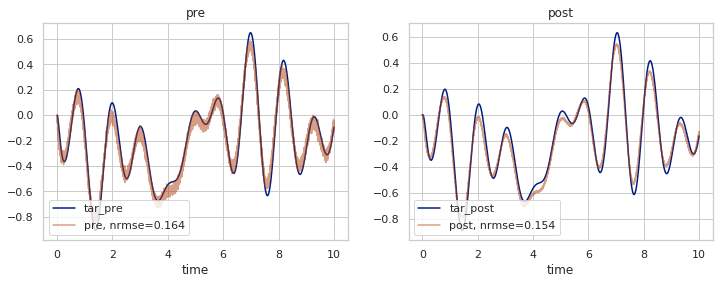

In [11]:
t_test = 10
dd3 = network(t=t_test, h_target=h_target, d_ampa=d_ampa, d_nmda=d_nmda, stim_func=stim_func)

times = dd3['trange']
a_pre_ampa = h_ampa.filt(dd3['pre'])
a_pre_nmda = h_nmda.filt(dd3['pre'])
tar_pre = h_target.filt(dd3['tar_pre'])
a_post = Lowpass(0.05).filt(dd3['post'])
tar_post = Lowpass(0.05).filt(dd3['tar_post'])

xhat_pre = np.dot(a_pre_ampa, d_ampa) + np.dot(a_pre_nmda, d_nmda)
xhat_post = np.dot(a_post, d_post)
nrmse_pre = nrmse(xhat_pre.reshape((xhat_pre.shape[0]), 1), target=tar_pre)
nrmse_post = nrmse(xhat_post, target=tar_post)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=((12, 4)))
ax.plot(times, tar_pre, label='tar_pre')
ax.plot(times, xhat_pre, label='pre, nrmse=%.3f'%nrmse_pre, alpha=0.5)
ax2.plot(times, tar_post, label='tar_post')
ax2.plot(times, xhat_post, label='post, nrmse=%.3f'%nrmse_post, alpha=0.5)
ax.set(xlabel='time', title='pre')
ax2.set(xlabel='time', title='post')
ax.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()

### test on new white noise signal (new seed)

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

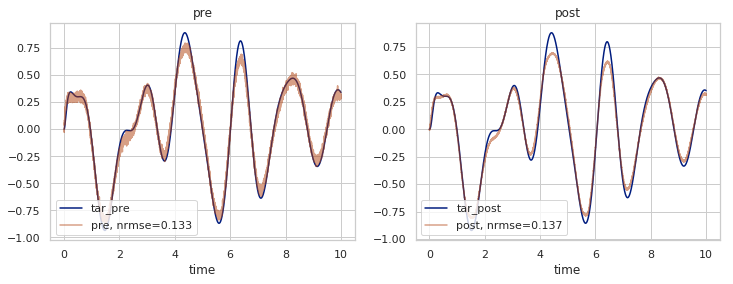

In [12]:
t_test = 10
stim_func = nengo.processes.WhiteSignal(period=t_train, high=1, rms=1, seed=1)

dd3 = network(t=t_test, h_target=h_target, d_ampa=d_ampa, d_nmda=d_nmda, stim_func=stim_func)

times = dd3['trange']
a_pre_ampa = h_ampa.filt(dd3['pre'])
a_pre_nmda = h_nmda.filt(dd3['pre'])
tar_pre = h_target.filt(dd3['tar_pre'])
a_post = Lowpass(0.05).filt(dd3['post'])
tar_post = Lowpass(0.05).filt(dd3['tar_post'])

xhat_pre = np.dot(a_pre_ampa, d_ampa) + np.dot(a_pre_nmda, d_nmda)
xhat_post = np.dot(a_post, d_post)
nrmse_pre = nrmse(xhat_pre.reshape((xhat_pre.shape[0]), 1), target=tar_pre)
nrmse_post = nrmse(xhat_post, target=tar_post)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=((12, 4)))
ax.plot(times, tar_pre, label='tar_pre')
ax.plot(times, xhat_pre, label='pre, nrmse=%.3f'%nrmse_pre, alpha=0.5)
ax2.plot(times, tar_post, label='tar_post')
ax2.plot(times, xhat_post, label='post, nrmse=%.3f'%nrmse_post, alpha=0.5)
ax.set(xlabel='time', title='pre')
ax2.set(xlabel='time', title='post')
ax.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()

## Inhibitory population

In [156]:
def network_inh(
    n_neurons=100,
    t=10.0,
    d_ampa=None,
    d_nmda=None,
    d_ampa_exc=None,
    d_nmda_exc=None,
    d_gaba=None,
    h_ampa=DoubleExp(0.00055, 0.0022),
    h_nmda=DoubleExp(0.0106, 0.285),
    h_gaba=Alpha(0.0015),
    h_target=Lowpass(0.05),
#     gain_inh=Default,
#     bias_inh=Default,
    enc_inh=Choice([[1]]),
    stim_func=lambda t: np.sin(t),
    seed=0,
    **kwargs):

    solver_ampa = LstsqL2(reg=0.1) if d_ampa is None else NoSolver(d_ampa)
    solver_nmda = LstsqL2(reg=0.1) if d_nmda is None else NoSolver(d_nmda)
    solver_ampa_exc = LstsqL2(reg=0.1) if d_ampa_exc is None else NoSolver(d_ampa_exc)
    solver_nmda_exc = LstsqL2(reg=0.1) if d_nmda_exc is None else NoSolver(d_nmda_exc)
    solver_ampa_shift = LstsqL2(reg=0.1) if d_ampa_shift is None else NoSolver(d_ampa_shift)
    solver_nmda_shift = LstsqL2(reg=0.1) if d_nmda_shift is None else NoSolver(d_nmda_shift)
    solver_gaba = LstsqL2(reg=0.1) if d_gaba is None else NoSolver(d_gaba)
        
    norm = get_norm(t, stim_func)

    with nengo.Network(seed=seed) as network:
        stim = nengo.Node(stim_func)
        pre = nengo.Ensemble(n_neurons, 1, seed=seed)
        inh = nengo.Ensemble(n_neurons, 1, seed=seed,
#             gain=gain_inh, bias=bias_inh,
            intercepts=Uniform(0, 1), encoders=enc_inh)
        post = nengo.Ensemble(n_neurons, 1, seed=seed)
        tar_pre = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        tar_post = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(stim, pre, transform=1.0/norm, synapse=Lowpass(0.05), seed=seed)
        nengo.Connection(pre, inh, solver=solver_ampa_shift, synapse=h_ampa, seed=seed)
        nengo.Connection(pre, inh, solver=solver_nmda_shift, synapse=h_nmda, seed=seed)
        nengo.Connection(pre, post, solver=solver_ampa_exc, synapse=h_ampa, seed=seed)
        nengo.Connection(pre, post, solver=solver_nmda_exc, synapse=h_nmda, seed=seed)
        nengo.Connection(inh, post, solver=solver_gaba, synapse=h_gaba, seed=seed)
        nengo.Connection(stim, tar_pre, transform=1.0/norm, synapse=Lowpass(0.05))
        nengo.Connection(tar_pre, tar_post, synapse=h_target)
        p_pre = nengo.Probe(pre.neurons, 'spikes', synapse=None)
        p_inh = nengo.Probe(inh.neurons, 'spikes', synapse=None)
#         p_post = nengo.Probe(post.neurons, 'spikes', synapse=None)
        p_post = nengo.Probe(post, synapse=Lowpass(0.05))
        p_tar_pre = nengo.Probe(tar_pre, synapse=None)
        p_tar_post = nengo.Probe(tar_post, synapse=None)
        
    with nengo.Simulator(network) as sim:
        sim.run(t)
        
    return dict(
        trange=sim.trange(),
        pre=sim.data[p_pre],
        inh=sim.data[p_inh],
        post=sim.data[p_post],
        tar_pre=sim.data[p_tar_pre],
        tar_post=sim.data[p_tar_post]
    )

In [157]:
%%script false
def func_pos(x):
    # take an input array and add a scaled quadratic centered at the array's midpoint
    t = np.linspace(-1, 1, x.shape[0])
    q = (t - t[int(x.shape[0]/2)]) * (t - t[int(x.shape[0]/2)])
    norm = np.max(q) / np.max(np.abs(x))
    q /= norm
    q += np.max(np.abs(x))
    q = q.reshape((q.shape[0], 1))
    pos = x + q
    return pos

In [158]:
def func_pos(x):
    return x + np.abs(np.min(x)) + np.max(x)

### optimize excitatory decoders

In [159]:
t_train = 10
stim_func = nengo.processes.WhiteSignal(period=t_train, high=1, rms=1, seed=0)
# stim_func = lambda t: -1 + 2*t/t_train
h_target = Lowpass(0.1)

dd1 = network_inh(t=t_train, stim_func=stim_func, h_target=h_target)

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

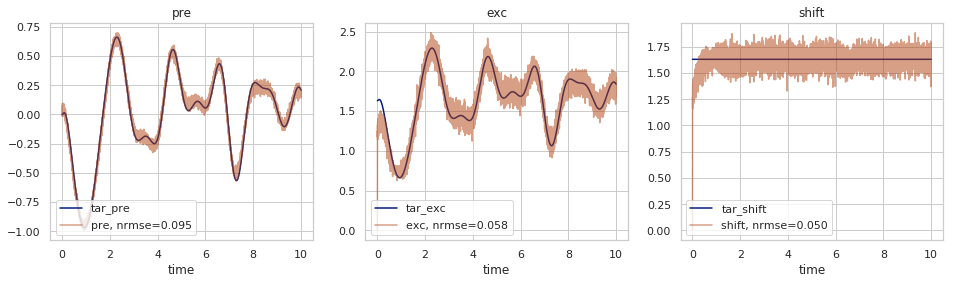

count d_exc=0 / d_total 0.56
count d_shift=0 / d_total 0.905


In [160]:
h_ampa = DoubleExp(0.00055, 0.0022)
h_nmda = DoubleExp(0.0106, 0.285)  # no voltage-dependent Mg2+ block
h_gaba = Alpha(0.0015)

times = dd1['trange']
a_pre_ampa = h_ampa.filt(dd1['pre'])
a_pre_nmda = h_nmda.filt(dd1['pre'])
tar_pre = h_target.filt(dd1['tar_pre'])

reg = 0.1

A = np.hstack((a_pre_ampa, a_pre_nmda))
D = LstsqL2(reg=reg)(A, tar_pre)[0]
d_ampa = D[:a_pre_ampa.shape[1]]
d_nmda = D[a_pre_ampa.shape[1]:]

tar_exc = func_pos(tar_pre)
D_exc = NnlsL2(reg=reg)(A, tar_exc)[0]
d_ampa_exc = D_exc[:a_pre_ampa.shape[1]]
d_nmda_exc = D_exc[a_pre_ampa.shape[1]:]

tar_shift = func_pos(tar_pre) - tar_pre
D_shift = NnlsL2(reg=reg)(A, tar_shift)[0]
d_ampa_shift = D_shift[:a_pre_ampa.shape[1]]
d_nmda_shift = D_shift[a_pre_ampa.shape[1]:]

xhat_pre = np.dot(a_pre_ampa, d_ampa) + np.dot(a_pre_nmda, d_nmda)
xhat_exc = np.dot(a_pre_ampa, d_ampa_exc) + np.dot(a_pre_nmda, d_nmda_exc)
xhat_shift = np.dot(a_pre_ampa, d_ampa_shift) + np.dot(a_pre_nmda, d_nmda_shift)
nrmse_pre = nrmse(xhat_pre.reshape((xhat_pre.shape[0]), 1), target=tar_pre)
nrmse_exc = nrmse(xhat_exc, target=tar_exc)
nrmse_shift = nrmse(xhat_shift, target=tar_shift)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=((16, 4)))
ax.plot(times, tar_pre, label='tar_pre')
ax.plot(times, xhat_pre, label='pre, nrmse=%.3f'%nrmse_pre, alpha=0.5)
ax2.plot(times, tar_exc, label='tar_exc')
ax2.plot(times, xhat_exc, label='exc, nrmse=%.3f'%nrmse_exc, alpha=0.5)
ax3.plot(times, tar_shift, label='tar_shift')
ax3.plot(times, xhat_shift, label='shift, nrmse=%.3f'%nrmse_shift, alpha=0.5)
ax.set(xlabel='time', title='pre')
ax2.set(xlabel='time', title='exc')
ax3.set(xlabel='time', title='shift')
ax.legend(loc='lower left')
ax2.legend(loc='lower left')
ax3.legend(loc='lower left')
plt.show()

print('count d_exc=0 / d_total', np.count_nonzero(D_exc)/D_exc.shape[0])
print('count d_shift=0 / d_total', np.count_nonzero(D_shift)/D_shift.shape[0])

## divide into positive and negative components
 - transform d_ampa and d_nmda to be positive (above, using non-negative least squares solver)
 - calculate the difference between the overall target and estimate computed with these positive decoders
 - represent this value in the inhibitory population
 - to do this, compute non-negative decoders that will estimate this function given PC excitatory activity
 - use these decoders on the PC-inh connection
 - ensure the that resulting weight matrix does not over- or under-stimulate inh using a further optimization of gains_inh

In [161]:
def optimize_inh(xhat_exc, n_neurons=100, n_samples=50, seed=0):
    with nengo.Network(seed=seed) as network:
        pre = nengo.Ensemble(n_neurons, 1, seed=seed)
        inh = nengo.Ensemble(n_neurons, 1, seed=seed, intercepts=Uniform(0, 1), encoders=Choice([[1]]))
        post = nengo.Ensemble(n_neurons, 1, seed=seed)
    sim = nengo.Simulator(network)
    enc = sim.data[inh].encoders  # fix
    gain = sim.data[inh].gain  # update
    bias = sim.data[inh].bias  # fix
    # sample x from state-space range of xhat_enc
    x_range = np.linspace(np.min(xhat_exc), np.max(xhat_exc), n_samples).reshape(n_samples, 1)
    # specify target input currents for each x in x_range
    J_min = 0
    J_max = sim.data[inh].max_rates
    J_range = np.zeros((n_neurons, n_samples))
    for n in range(n_neurons):
        J_range[n,:] = np.linspace(J_min, J_max[n], n_samples)
    # least squares optimization of new gains
    # J = alpha (x dot e) + bias   ==>   (J-bias) = (x dot e) * alpha  <==> target = A * decoders
#     print('gain before', gain)
    target = J_range - np.dot(bias.reshape(n_neurons, 1), np.ones((1, n_samples)))
    A = gain * np.dot(x_range, enc.T)
    gain_new = NnlsL2(reg=reg)(A, target.T)[0]
    gain_new = gain_new[0,:]
#     print('gain after', gain_new)
    # roll new gain into encoder to avoid disrupting max_rates and intercepts
    enc_new = gain_new * enc
    return enc_new[0, :].reshape((n_neurons, 1))

In [163]:
# stim_func = lambda t: -1 + 2*t/t_train
stim_func = nengo.processes.WhiteSignal(period=t_train, high=1, rms=1, seed=0)

enc_inh = optimize_inh(xhat_exc)

dd2 = network_inh(t=t_train, stim_func=stim_func, h_target=h_target,
    d_ampa=d_ampa, d_nmda=d_nmda,
    d_ampa_exc=d_ampa_exc, d_nmda_exc=d_nmda_exc,
    d_ampa_shift=d_ampa_shift, d_nmda_shift=d_nmda_shift,
    enc_inh=enc_inh)

cannot import or initialize NEURON


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

cannot import or initialize NEURON
cannot import or initialize NEURON


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero a_inh 1.0
count d_inh=0 / d_total 0.89


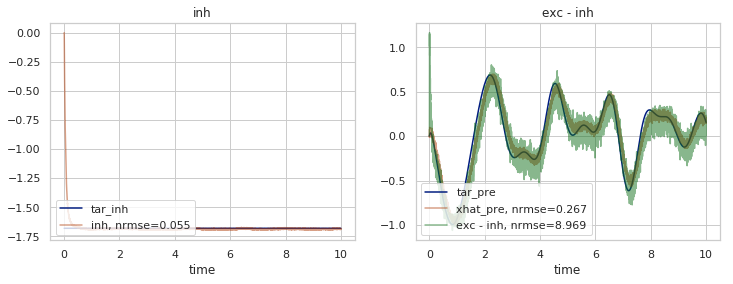

In [170]:
times = dd2['trange']
# a_inh = h_gaba.filt(dd2['inh'])
a_inh = Lowpass(0.05).filt(dd2['inh'])
a_pre_ampa = h_ampa.filt(dd2['pre'])
a_pre_nmda = h_nmda.filt(dd2['pre'])
a_exc = np.hstack((a_pre_ampa, a_pre_nmda))
a_pre = np.hstack((a_pre_ampa, a_pre_nmda))
# d_exc = np.vstack((d_ampa_exc, d_nmda_exc))
# d_pre = np.vstack((d_ampa, d_nmda))

tar_pre = dd2['tar_pre']
# tar_exc = tar_pre + np.abs(np.min(tar_pre)) + np.max(tar_pre)
tar_exc = func_pos(tar_pre)
# xhat_exc = np.dot(a_exc, d_exc)
# xhat_pre = np.dot(a_pre, d_pre)
xhat_exc = np.dot(a_pre_ampa, d_ampa_exc) + np.dot(a_pre_nmda, d_nmda_exc)
xhat_pre = np.dot(a_pre_ampa, d_ampa) + np.dot(a_pre_nmda, d_nmda)
nrmse_pre = nrmse(xhat_pre, target=tar_pre)

# tar_inh = xhat_exc - xhat_pre  # overshoot estimate from pos decoders minus estimate from mixed decoders
tar_inh = tar_exc - tar_pre  # overshoot estimate from pos decoders minus ideal target

reg = 0.1
d_gaba = -NnlsL2(reg=reg)(a_inh, tar_inh)[0]
# fig, ax = plt.subplots(figsize=((6, 4)))
# ax.plot(a_inh[:1000,:])
# plt.show()
print('nonzero a_inh', np.count_nonzero(np.sum(a_inh, axis=0))/a_inh.shape[1])
print('count d_inh=0 / d_total', np.count_nonzero(d_gaba)/d_gaba.shape[0])
# print(np.sum(a_inh, axis=0))
# d_gaba = LstsqL2(reg=reg)(a_inh, tar_inh)[0]

xhat_inh = np.dot(a_inh, d_gaba)
nrmse_inh = nrmse(xhat_inh, target=-tar_inh)
nrmse_diff = nrmse(xhat_exc - xhat_inh, target=xhat_pre)


fig, (ax, ax2) = plt.subplots(1, 2, figsize=((12, 4)))
ax.plot(times, -tar_inh, label='tar_inh')
ax.plot(times, xhat_inh, label='inh, nrmse=%.3f'%nrmse_inh, alpha=0.5)
ax2.plot(times, tar_pre, label='tar_pre')
ax2.plot(times, xhat_pre, label='xhat_pre, nrmse=%.3f'%nrmse_pre, alpha=0.5)
ax2.plot(times, xhat_exc + xhat_inh, label='exc - inh, nrmse=%.3f'%nrmse_diff, alpha=0.5)
ax.set(xlabel='time', title='inh')
ax2.set(xlabel='time', title='exc - inh')
ax.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()

### connect inh to post with -d_inh, pre to post with d_exc, and compare to the target

In [ ]:
dd3 = network_inh(t=t_train, stim_func=stim_func, h_target=h_target,
    d_ampa=d_ampa, d_nmda=d_nmda,
    d_ampa_exc=d_ampa_exc, d_nmda_exc=d_nmda_exc,
    d_ampa_shift=d_ampa_shift, d_nmda_shift=d_nmda_shift,
    d_gaba=d_gaba, enc_inh=enc_inh)

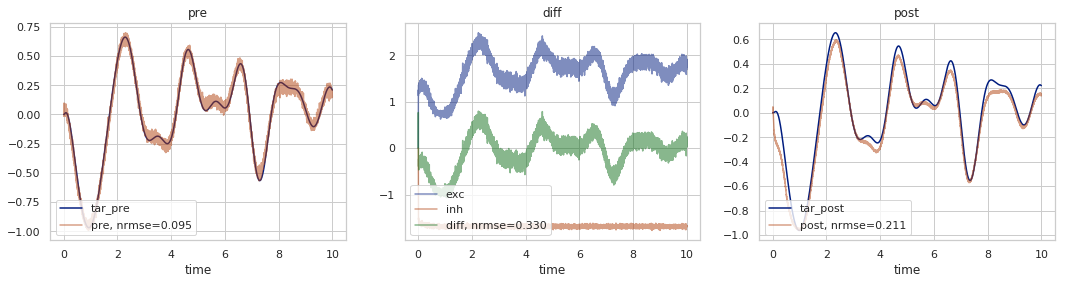

In [174]:
a_pre_ampa = h_ampa.filt(dd3['pre'])
a_pre_nmda = h_nmda.filt(dd3['pre'])
tar_pre = h_target.filt(dd3['tar_pre'])
a_post = Lowpass(0.05).filt(dd3['post'])
tar_post = Lowpass(0.05).filt(dd3['tar_post'])
# d_post = LstsqL2(reg=reg)(a_post, tar_post)[0]
a_inh = h_gaba.filt(dd3['inh'])
a_pre_ampa = h_ampa.filt(dd3['pre'])
a_pre_nmda = h_nmda.filt(dd3['pre'])
a_exc = np.hstack((a_pre_ampa, a_pre_nmda))

xhat_pre = np.dot(a_pre_ampa, d_ampa) + np.dot(a_pre_nmda, d_nmda)
xhat_exc = np.dot(a_pre_ampa, d_ampa_exc) + np.dot(a_pre_nmda, d_nmda_exc)
xhat_inh = np.dot(a_inh, d_gaba)
xhat_diff = xhat_exc + xhat_inh
# xhat_post = np.dot(a_post, d_post)
xhat_post = dd3['post']
nrmse_pre = nrmse(xhat_pre.reshape((xhat_pre.shape[0]), 1), target=tar_pre)
nrmse_post = nrmse(xhat_post, target=tar_post)
nrmse_diff = nrmse(xhat_diff, target=tar_post)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=((18, 4)))
ax.plot(times, tar_pre, label='tar_pre')
ax.plot(times, xhat_pre, label='pre, nrmse=%.3f'%nrmse_pre, alpha=0.5)
ax2.plot(times, xhat_exc, label='exc', alpha=0.5)
ax2.plot(times, xhat_inh, label='inh', alpha=0.5)
ax2.plot(times, xhat_diff, label='diff, nrmse=%.3f'%nrmse_diff, alpha=0.5)
ax3.plot(times, tar_post, label='tar_post')
ax3.plot(times, xhat_post, label='post, nrmse=%.3f'%nrmse_post, alpha=0.5)
ax.set(xlabel='time', title='pre')
ax2.set(xlabel='time', title='diff')
ax3.set(xlabel='time', title='post')
ax.legend(loc='lower left')
ax2.legend(loc='lower left')
ax3.legend(loc='lower left')
plt.show()